In [1]:
import os
import requests
import random
import matplotlib.pyplot as plt
import pandas as pd
# "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
pdf_path = "human-nutrition-text.pdf"

In [2]:
import fitz 
from tqdm.auto import tqdm 

# convert pdf to text
doc = fitz.open(pdf_path) 
pages_and_texts = []
for page_number, page in tqdm(enumerate(doc)):
    text = page.get_text() 
    text = text.replace("\n", " ").strip()
    pages_and_texts.append({"page_number": page_number+1,  "text": text})

c:\Users\Zekai\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
1208it [00:00, 1390.50it/s]


In [3]:
from spacy.lang.en import English 

# seperate text into sentences
nlp = English()
nlp.add_pipe("sentencizer")
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]


100%|██████████| 1208/1208 [00:01<00:00, 828.03it/s]


In [4]:
# stats
sents_pages = []
for item in pages_and_texts:
    for s in item['sentences']:
        sents_pages.append({'page': item['page_number'], 'text': s, 'char_count': len(s), 'word_count': len(s.split(' '))})

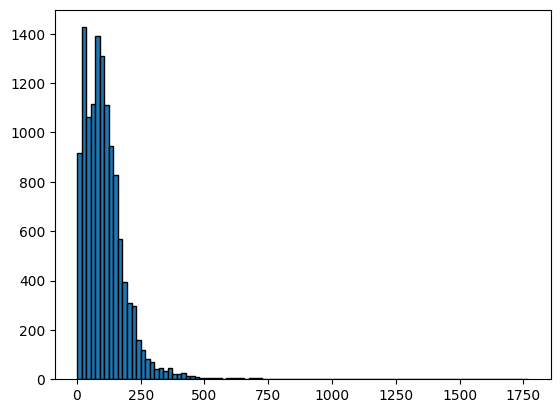

In [5]:
sentence_char_count = [item['char_count'] for item in sents_pages]
plt.hist(sentence_char_count, bins=100, edgecolor='black')
plt.show()

In [6]:
pd.DataFrame(sentence_char_count).describe()

,0
count,12466.000000
mean,110.413284
std,95.731982
min,2.000000
25%,50.000000
50%,95.000000
75%,145.000000
max,1769.000000


In [7]:
# split long sentences into short ones less then 500
def split_string(s, chunk_size=500):
    return [s[i:i+chunk_size] for i in range(0, len(s), chunk_size)]

sents_pages_new = []
for item in sents_pages:
    if item['char_count']>500:
        new_sents = split_string(item['text'])
        for s in new_sents:
            sents_pages_new.append({'page': item['page'], 'text': s, 'char_count': len(s), 'word_count': len(s.split(' '))})
    else:
        sents_pages_new.append(item)

sents_pages = sents_pages_new

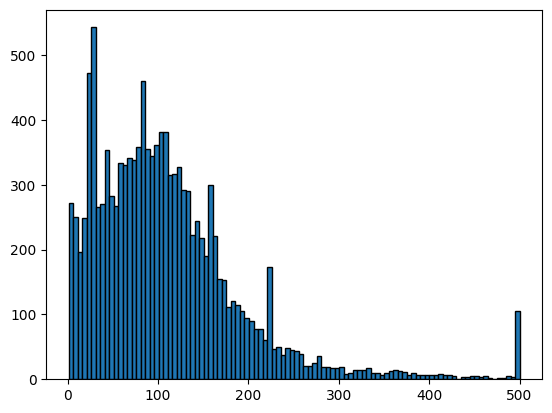

In [8]:
sentence_char_count = [item['char_count'] for item in sents_pages]
plt.hist(sentence_char_count, bins=100, edgecolor='black')
plt.show()

In [9]:
# sliding window through all the text
# each chunk has up to 2000 chars, 50 % sentence overlap ratio
# for sentence a b c d e f
# first chunk: a b c d (total 1800 chars)
# second chunk: c d e (total 1900 chars)
# 3rd chunk: d e f ...
# this overlaping help to improve recall

limit=2000
overlap_ratio=0.5

chunks = []
current_group = []
current_length = 0
i = 0

while i < len(sents_pages):  
    item = sents_pages[i]
    # Check if adding this string would exceed the limit
    if current_length + item['char_count'] > limit:
        # Finalize current group
        temp_sents = [temp_item['text'] for temp_item in current_group]
        temp_pages = [temp_item['page'] for temp_item in current_group]
        chunks.append({'pages': temp_pages, "sentences": temp_sents})
        
        overlap_count = max(1, int(len(current_group) * overlap_ratio))
        # Start next group with overlapping strings from the end of current group
        current_group = current_group[-overlap_count:]
        current_length = sum([s['char_count'] for s in current_group])
    
    # Add the current string if it fits
    else:
        current_group.append(item)
        current_length += (item['char_count']+1)
        i += 1


# Add the last group if it has content
if current_group:
    temp_sents = [temp_item['text'] for temp_item in current_group]
    temp_pages = [temp_item['page'] for temp_item in current_group]
    chunks.append({'pages': temp_pages, "sentences": temp_sents})

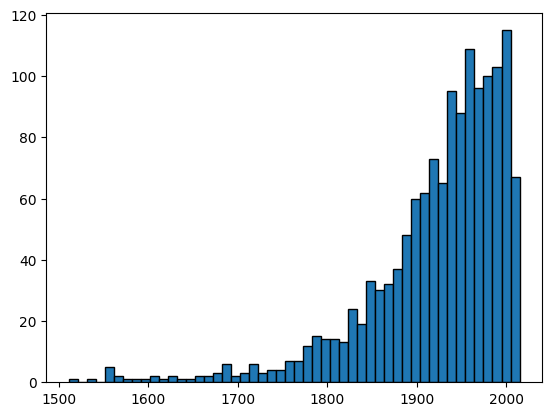

In [ ]:
# plot chunk sizes. due to concatenation, some chunks is little bit over 2000
chunk_char_count = [len(" ".join(item['sentences'])) for item in chunks]
plt.hist(chunk_char_count, bins=50, edgecolor='black')
plt.show()

In [11]:
# make two arrays for page and documents
# later when get index of neede documents, can get its page for better reference
pages = []
documents = []
sentences = []
for c in chunks:
    pages.append(c['pages'])
    documents.append(" ".join(c['sentences']).replace("  ", " "))
    sentences.append(c['sentences'])

In [12]:
from sentence_transformers import SentenceTransformer
# Load the model
model = SentenceTransformer("Qwen/Qwen3-Embedding-0.6B", device='cuda')
docu_embeddings = model.encode(documents, batch_size=8)

In [13]:
query = ["how to measure protein quality"]
query_embeddings = model.encode(query, prompt_name="query", batch_size=16)

In [14]:
similarity = model.similarity(query_embeddings, docu_embeddings)

In [15]:
import torch
topk_vals, topk_idx = torch.topk(similarity, k=5)
topk_idx = topk_idx.sort().values.numpy()[0]


In [16]:
# get the pages 
context_pages = []
context = []
for i in topk_idx:
    context.extend(sentences[i])
    context_pages.extend(pages[i])

In [17]:
from collections import OrderedDict

# since we have overlap in chunks, we need deduplication
# we want to keep the order of the content same as the pages, so use ordered dict
context = list(OrderedDict.fromkeys(context))
context_pages = list(OrderedDict.fromkeys(context_pages))

In [ ]:
" ".join(context)

'It is composed of four  peptides that bond together to form a functional oxygen carrier.  A protein’s structure also influences its nutritional quality. Large  fibrous protein structures are more difficult to digest than smaller  proteins and some, such as keratin, are indigestible. Because  digestion of some fibrous proteins is incomplete, not all of the  amino acids are absorbed and available for the body to utilize,  thereby decreasing their nutritional value.  Figure 6.5 The Four Structural Levels of Proteins  Defining Protein  |  371 Image by  OpenStax /  CC BY 4.0  Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities. \xa0 These activities are  372  |  Defining Protein available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, howe

In [19]:
context_pages

[413, 414, 415, 416, 456, 457, 458, 459, 460, 466, 467]